In [8]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

# IV) Создаем новый признак

Для того чтобы определить страну производитель было решено сначала разделить название на производителя и модель в исходном дата сете, затем глянуть на наших производителей и создать словарь с нашими производителями и странами

In [9]:
df = pd.read_csv('data_processed.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
df.insert(1, 'Марка', df['Название'].str.split(' ', 1, expand=True)[1])
df['Название'] = df['Название'].str.split(' ', 1, expand=True)[0]
df.rename(columns = {'Название': 'Производитель'}, inplace = True)

Путем поиска в интернетах создаем словарик...

In [11]:
slovar = {'Kia': 'Южная Корея', 'Hyundai': 'Южная Корея', 'Toyota': 'Япония', 'Jeep': 'США',
          'Mercedes-Benz': 'Германия', 'Лада': 'Россия', 'BMW': 'Германия','ГАЗ': 'Россия',
          'Changan': 'Китай', 'Infiniti': 'Япония', 'Audi': 'Германия', 'Volkswagen': 'Германия',
          'Great Wall': 'Китай', 'Honda': 'Япония', 'Nissan': 'Япония', 'SsangYong': 'Южная Корея', 
          'Skoda': 'Чехия', 'Volvo': 'Швеция', 'Land Rover': 'Британия', 'Chevrolet': 'США',
          'Mazda': 'Япония', 'Opel': 'Германия', 'Peugeot': 'Франция', 'Rivian': 'США',
          'Renault': 'Франция', 'Mitsubishi': 'Япония', 'Tesla': 'США', 'Lexus': 'Япония',
          'Ford': 'США', 'Bentley': 'Британия', 'Subaru': 'Япония', 'Porsche': 'Германия',
          'Dodge': 'США', 'Fiat': 'Италия', 'Suzuki': 'Япония', 'Haval': 'Китай', 'УАЗ': 'Россия',
          'Geely': 'Китай', 'Chery': 'Китай', 'EXEED': 'Китай', 'Genesis': 'Южная Корея',
          'Dongfeng': 'Китай', 'Citroen': 'Германия', 'BYD': 'Китай', 'Jaguar': 'Британия',
          'Tank': 'Китай', 'ЗАЗ': 'Россия', 'Daewoo': 'Южная Корея', 'Kaiyi': 'Китай',
          'MINI': 'Британия', 'Datsun': 'Япония', 'Москвич': 'Россия', 'SEAT': 'Испания',
          'Cadillac': 'США', 'Daihatsu': 'Япония', 'Voyah': 'Китай', 'GMC': 'США', 'Chrysler': 'США',
          'Lifan': 'Китай', 'Isuzu': 'Япония', 'Ferrari': 'Италия', 'Smart': 'Германия',
          'Evolute': 'Россия', 'RAM': 'США', 'Maybach': 'Германия'}

Во время сбора словарика были найдены производители с названием из двух и более слов: Land Rover, Great Wall. Заменим их модели и название производителей.

Более того была найдена машина Jetta совместного производства Китая и Volkswagen. Так как это пилотный проект, то было решено вообще выкинуть этот мусор

In [12]:
df.set_index('Производитель', inplace = True)
df.drop('Jetta', inplace = True)
df.rename(index = {'Great': 'Great Wall', 'Land': 'Land Rover'}, inplace = True)
df.reset_index(inplace = True)

for i in df[df['Производитель'] == 'Land Rover']['Марка'].values:
    df.replace(i, i.replace('Rover ', '', 1), inplace = True)
    
for i in df[df['Производитель'] == 'Great Wall']['Марка'].values:
    df.replace(i, i.replace('Wall ', '', 1), inplace = True)

countries = []
for i in list(df['Производитель'].values):
    countries.append(slovar[i])
df.insert(2, 'Страна', countries)


In [13]:
df.to_csv('new_data_processed.csv')

Приступим к проверке гипотезы "Среднее значение цен на западные автомобили равно среднему значению цен на восточные". То есть:

$$
\begin{aligned}
&H_0:  \mu(восток)\ = \mu(запад)\\
&H_1:  \mu(восток)\ \not=\ \mu(запад)\\
\end{aligned}
$$

Рассмотрим, что мы относим к западу и востоку

In [14]:
df['Страна'].unique()

array(['Южная Корея', 'Япония', 'США', 'Германия', 'Россия', 'Китай',
       'Чехия', 'Швеция', 'Британия', 'Франция', 'Италия', 'Испания'],
      dtype=object)

In [15]:
west = np.array(['США', 'Германия', 'Чехия', 'Швеция', 'Британия', 'Франция', 'Италия', 'Испания'])
east = ['Южная Корея', 'Япония', 'Россия', 'Китай']

Проверим распределение цен наших автомобилей

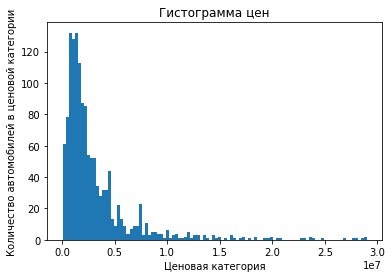

In [16]:
plt.hist(df['Цена'], bins = 100)
plt.title('Гистограмма цен')
plt.xlabel('Ценовая категория')
plt.ylabel('Количество автомобилей в ценовой категории');

Гистограмма очень похожа на хи квадрат, который в ассимптотике сможет дать нормальное распределение, поэтому мы сможем воспользоваться этим свойством для проверки гипотезы.

Мы не знаем нашу истинную дисперсию, поэтому воспользуемся ее несмещенной оценкой..

Возьмем уровень доверия 95%

In [17]:
idx_w = []
idx_e = []
for i in df['Страна']:
    if i in west:
        idx_w.append(True)
        idx_e.append(False)
    else:
        idx_w.append(False)
        idx_e.append(True)

df_w = df[idx_w]
df_e = df[idx_e]

sigma = np.sqrt((df_e['Цена'].var(ddof = 1) * (df_e.size - 1) + df_w['Цена'].var(ddof = 1) * (df_w.size - 1)) 
 / (df_w.size + df_e.size - 2))

t_rasch = (df_w['Цена'].mean() - df_e['Цена'].mean()) / (sigma * np.sqrt((1 / df_e.size) + (1 / df_w.size)))
t_kr = sts.t(df = df_e.size + df_w.size - 2).ppf(0.05/2)


In [18]:
sigma = np.sqrt((df_e['Цена'].var(ddof = 1) * (df_e.size - 1) + df_w['Цена'].var(ddof = 1) * (df_w.size - 1)) 
 / (df_w.size + df_e.size - 2))

t_rasch = (df_w['Цена'].mean() - df_e['Цена'].mean()) / (sigma * np.sqrt((1 / df_e.size) + (1 / df_w.size)))
t_kr = sts.t(df = df_e.size + df_w.size - 2).ppf(0.05/2)

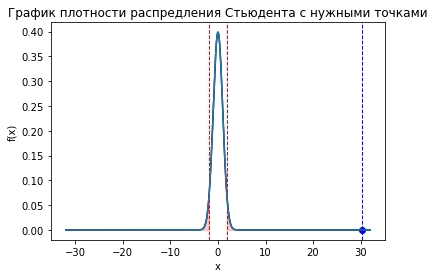

In [19]:
x = np.linspace(-32, 32, 1000)
pdf = sts.t(df=df_e.size + df_w.size - 2).pdf(x)
plt.plot(x, pdf, color = 'black')

plt.scatter(t_rasch, [sts.t(df=df_e.size + df_w.size - 2).pdf(t_rasch)], color="blue")
plt.axvline(t_rasch, color='blue', linestyle="--", lw=1)

plt.axvline(t_kr, color='red', linestyle="--", lw=1)
xq = np.linspace(-32, t_kr, 100)
yq = sts.t(df=df_e.size + df_w.size - 2).pdf(xq)
plt.fill_between(xq, 0, yq, color='red', alpha=0.2)

plt.axvline(-1 * t_kr, color='red', linestyle="--", lw=1)
xq = np.linspace(-1 * t_kr, 32, 100)
yq = sts.t(df=df_e.size + df_w.size - 2).pdf(xq)
plt.fill_between(xq, 0, yq, color='red', alpha=0.2)

plt.plot(x, pdf)
plt.ylabel('f(x)')
plt.xlabel('x')
plt.title('График плотности распредления Стьюдента с нужными точками');

In [20]:
print('Расчетная точка:',  t_rasch)
print('Критические точки: ',  -1 * t_kr, ', ', t_kr, sep = '')

Расчетная точка: 30.34321831511047
Критические точки: 1.960087961271559, -1.960087961271559


Собственного говоря, мы можем отвергнуть нашу гипотезу. Это видно и по графику выше

> Гипотез много. Например, выше, во время обработки данных и EDA мы заметили раритетную машину 1950 года. Интересно, она одна такая? Или их значимое количество, если поискать? 

Может ли цена зависеть от года выпуска прямо - чем меньше год выпуска, т.е. старее машина - тем выше цена?

<img src="photo_2023-06-14_20-24-58.jpg" width="500" height="340">

### Шутка! проверяем:

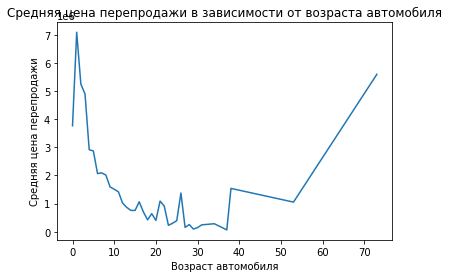

In [21]:
df['Год'] = pd.to_numeric(df['Год'])

# Создание нового столбца 'Возраст'
current_year = 2023  # Текущий год
df['Возраст'] = current_year - df['Год']

# Группировка данных по возрасту автомобилей и вычисление средней цены для каждой группы
age_price = df.groupby('Возраст')['Цена'].mean()

# Построение графика для визуализации результатов
plt.plot(age_price.index, age_price.values)
plt.xlabel('Возраст автомобиля')
plt.ylabel('Средняя цена перепродажи')
plt.title('Средняя цена перепродажи в зависимости от возраста автомобиля')
plt.show()

In [22]:
df.loc[df.Возраст > 35].head()

,Производитель,Марка,Страна,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена,Возраст
12,ГАЗ,14 Чайка,Россия,1985,бензин,5.5,220.0,автомат,задний,черный,39316,левый,8.602,3000000,38
161,Лада,2101,Россия,1986,бензин,1.3,64.0,механика,задний,бежевый,100000,левый,7.500,60000,37
543,Лада,4x4 2121 Нива,Россия,1987,бензин,1.6,73.0,механика,4WD,бежевый,69000,левый,8.602,152000,36
548,Лада,2102,Россия,1985,бензин,1.6,64.0,механика,задний,бежевый,99999,левый,8.602,75000,38
885,BMW,340,Германия,1950,бензин,2.0,55.0,механика,задний,черный,50000,левый,8.602,5600000,73


> Что ж, немолодых автомобилей у нас оказалось не так много, как хотелось бы, но учитывая, что на 3 машины из 5 имеющихся возрастом сташе 35 лет стоимость больше миллиона и на графике четко видно, что она растет с возрастом - данная зависимость имеет место быть.

Хорошо, но можно ли говорить, что цена автомобиля обусловлена его возрастом и пробегом и прочими факторами, но при этом в целом не так то и важно, какая марка машины это изначально была?

In [24]:
brand_price = df.groupby('Производитель')['Цена'].mean()

# Выполнение однофакторного ANOVA
fvalue, pvalue = sts.f_oneway(*[group['Цена'] for brand, group in df.groupby('Производитель')])

# Вывод результатов
print("F-значение:", fvalue)
print("p-value:", pvalue)

F-значение: 12.02950298125449
p-value: 9.93443250823884e-92


Кажется, нет. Из-за большого F-значения можно утверждать, что марка авто значительно влияет на его цену, а столь маленький p-value (e-92!!!!) говорит о том, что ошибка тут явно исключена


# V) Тачковое обучение 
(потому что мы про тачки/машинки делаем проект, прикольно да?:)


<img src = 2741968780.png/\
svg.png width = "500" height = "500" >

Мы решили много не думать, поэтому наша модель будет предсказывать цену автомобиля. Так как мы предсказываем действительное число, то будем пользоваться регрессией 

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn. preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn. linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [182]:
df = pd.read_csv('new_data_processed.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)

df['Производитель'] = df['Производитель'] + ' ' + df['Марка']
df.drop('Марка', axis = 1, inplace = True)
df.rename(columns = {'Производитель': 'Название'}, inplace = True)

In [183]:
df_1 = df[['Год', 'Объем двигателя', 'Мощность', 'Пробег', 'Оценка Drom', 'Цена']]
df_train, df_test = train_test_split(df_1, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

__Линейная регрессия__

In [184]:
model = LinearRegression()

model.fit(X_train, y_train)
y_pr = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pr))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 1.1839
Train MAPE = 0.9737


In [185]:
#наш наивный прогноз

y_naive_pred = np.median(y_train) * np.ones_like(y_test)
mean_absolute_percentage_error(y_naive_pred, y_pr)

1.099210076425752

Наша модель предсказывает хуже, чем наивный проноз, постараемся улучшить как это возможно...

In [186]:
# скалируем данные

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

model.fit(X_train_scale, y_train)
y_pr_ss = model.predict(X_test_scale)
y_train_pr_ss = model.predict(X_train_scale)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pr_ss))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pr_ss))

Test MAPE = 1.1839
Train MAPE = 0.9737


Ничего не поменялось, идем дальше.. Применим одно горячее кодирование к категориальным признакам и скалирование для числовых

In [189]:
X = df.drop(columns=['Цена'])

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
])

Linear_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegression())
])

model = Linear_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 1.8266
Train MAPE = 0.5157


Стало совсем чуть лучше. Попробуем применить Lasso - регрессию

In [191]:
X = df.drop(columns=['Цена'])

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
])

Lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = Lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 1.4863
Train MAPE = 0.5159


Снова получше, но это капля в море, стараемся дальше. Попробуем подобрать альфу, чтобы хотя бы как-то улучшить эти зашкилавающие значения

In [192]:
alphas = np.logspace(-6, 6, 200)
searcher = GridSearchCV(Lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [194]:
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 1.3762
Train MAPE = 0.7664


Прекрасно. Нам ничего не помогает улучшить Линейную регрессию до адекватных значений, поэтому она отправляется куда подальше. Рассмотрим другую модель

__Ближайшие соседи__

In [215]:
#пробуем модель без ничего

df_1 = df[['Год', 'Объем двигателя', 'Мощность', 'Пробег', 'Оценка Drom', 'Цена']]
df_train, df_test = train_test_split(df_1, test_size=0.2, random_state=101)
#наш таргет
y_train = df_train['Цена']
y_test = df_test['Цена']

#наши признаки
X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

model = KNeighborsClassifier(n_neighbors=10, p = 2, weights='distance')

model.fit(X_train, y_train)
y_pr = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pr))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.8989
Train MAPE = 0.0071


Самая простая модель ближайших соседей только на числовых признаках предсказывает лучше всех выше перечисленных

In [216]:
# скалируем данные

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

model.fit(X_train_scale, y_train)
y_pr_ss = model.predict(X_test_scale)
y_train_pr_ss = model.predict(X_train_scale)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pr_ss))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pr_ss))

Test MAPE = 0.3225
Train MAPE = 0.0071


In [217]:
# нормируем данные
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

model.fit(X_train_norm, y_train)
y_pr_s = model.predict(X_test_norm)
y_train_pr_s = model.predict(X_train_norm)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pr_s))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pr_s))

Test MAPE = 0.6997
Train MAPE = 0.0071


Нормирование тоже не помогает, и хотя бы проскалированные данные показали результат получше. Хвала небесам. Попробуем присобачить категориальные переменные

In [211]:
X = df.drop(columns=['Цена'])

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
])

KNN_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('KNN', KNeighborsClassifier(2))
])

model = KNN_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.2754
Train MAPE = 0.0986


In [198]:
df_jopa = df[['Год', 'Объем двигателя', 'Мощность', 'Пробег', 'Оценка Drom', 'Цена']]
df_train, df_test = train_test_split(df_jopa, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)


model = RandomForestClassifier()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.3389
Train MAPE = 0.0069


In [199]:
X = df.drop(columns=['Цена'])

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('model', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.3926
Train MAPE = 0.0020


In [201]:
X = df.drop(columns=['Цена'])

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)


column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('estimator', RandomForestClassifier())
])

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 30)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 30)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 20)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 20)]
bootstrap = [True, False]
param_dist = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}
rs = RandomizedSearchCV(pipeline, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 4, 
                        scoring = mean_absolute_percentage_error,
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(X_train, y_train)
y_pred = rs.predict(X_test)
y_train_pred = rs.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Test MAPE = 0.7425
Train MAPE = 0.7614


Исходя из вышеполученного можно сделать вывод, что самая лучшая модель показала MAPE = 0.2754, и это модель...

In [202]:
X = df.drop(columns=['Цена'])

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

numeric_features = X.select_dtypes([np.number]).columns
categorical_features = X.dtypes[X.dtypes == "object"].index

df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
])

KNN_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('KNN', KNeighborsClassifier(2))
])

model = KNN_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.2754
Train MAPE = 0.0986


<img src="photo_2023-06-14_19-48-52.jpg" width="500" height="340">

# Спасибо за внимание!